/home/bohdan/work/ml/programs/anaconda3/envs/bone/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 9/36808 [00:00<07:23, 82.96it/s]

train shape: (36808, 4)


100%|██████████| 36808/36808 [11:13<00:00, 54.65it/s] 


Few images with shape: (360, 360)


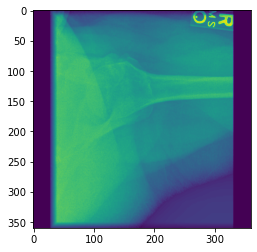

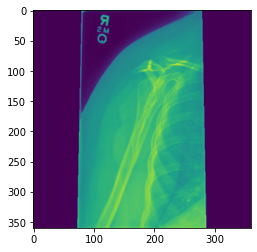

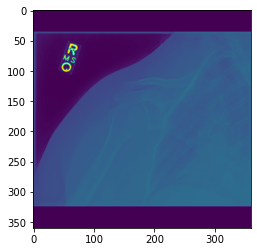

  0%|          | 11/3197 [00:00<00:32, 97.08it/s]

Loaded 36808 images and 36808 labels for the current dataset
time for creating Train dataset: 11.23  mins


100%|██████████| 3197/3197 [00:57<00:00, 56.03it/s] 


Few images with shape: (360, 360)


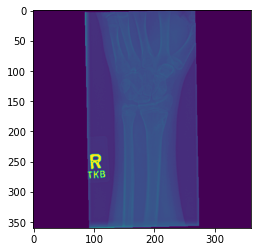

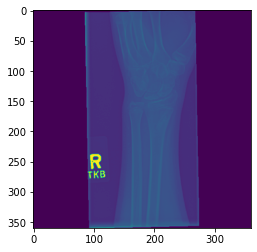

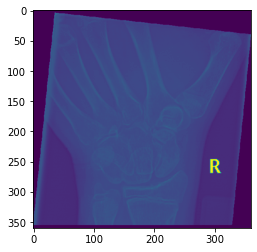

Loaded 3197 images and 3197 labels for the current dataset
image_plot: (360, 360, 3)


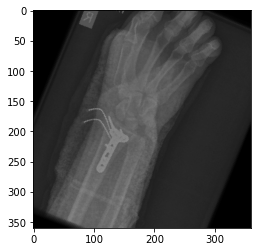

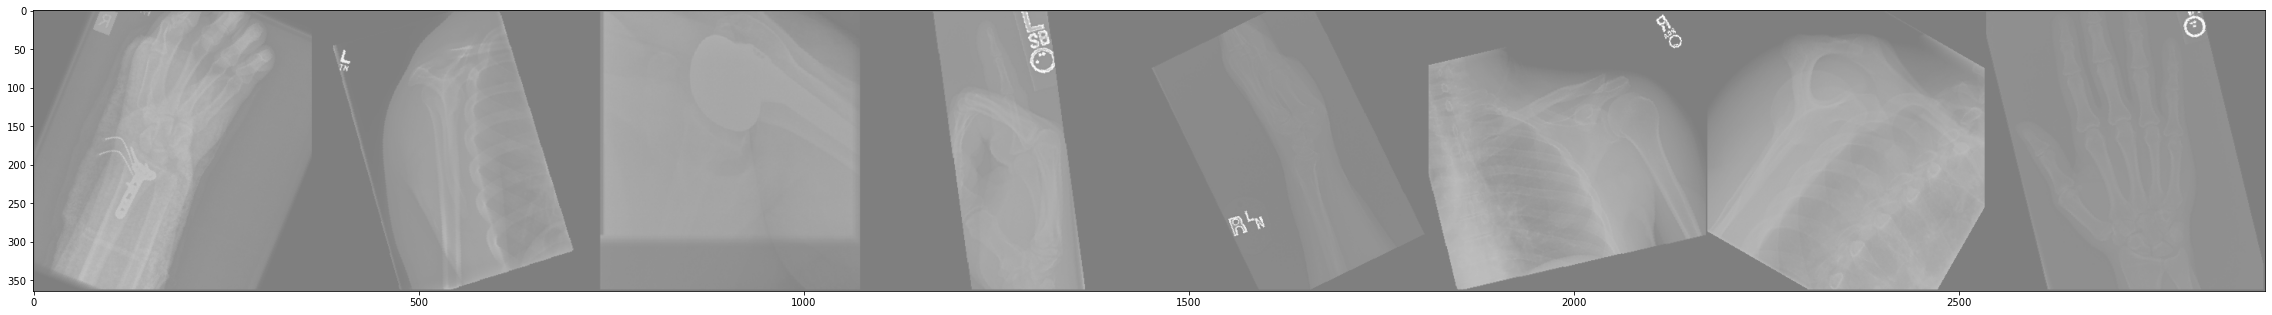

  0%|          | 0/15 [00:00<?, ?it/s]




Epoch : 1
validation list_outputs[:10]: [[0.07574446]
 [0.07211273]
 [0.23290934]
 [0.6166697 ]
 [0.39344987]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.16927866713977643 
Validation Loss : 0.199908293970104 
Kappa score : 0.6723345858545561 
AUC ROC score : 0.8395711224403822 
Accuracy : 0.8370347200500469
Validation Loss decreased from inf to  0.199908293970104 ....Saving model


  7%|▋         | 1/15 [15:24<3:35:43, 924.55s/it]




Epoch : 2
validation list_outputs[:10]: [[0.05703669]
 [0.05575757]
 [0.28532362]
 [0.66307765]
 [0.44534984]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.16261410251926972 
Validation Loss : 0.20358896069869534 
Kappa score : 0.6721048233340585 
AUC ROC score : 0.8406993314040515 
Accuracy : 0.8370347200500469


 13%|█▎        | 2/15 [34:16<3:33:47, 986.69s/it]




Epoch : 3
validation list_outputs[:10]: [[0.06563673]
 [0.05199209]
 [0.27157074]
 [0.6128314 ]
 [0.43752074]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.15924025270209394 
Validation Loss : 0.20294116075568117 
Kappa score : 0.6728135975900893 
AUC ROC score : 0.8406054618379144 
Accuracy : 0.8373475132937128


 20%|██        | 3/15 [53:06<3:25:58, 1029.88s/it]




Epoch : 4
validation list_outputs[:10]: [[0.09809959]
 [0.09157774]
 [0.43230385]
 [0.6930386 ]
 [0.48561323]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.15609828735503573 
Validation Loss : 0.20851323088007045 
Kappa score : 0.6621262291742724 
AUC ROC score : 0.8351469545190108 
Accuracy : 0.8320300281513919


 27%|██▋       | 4/15 [1:10:02<3:08:01, 1025.62s/it]




Epoch : 5
validation list_outputs[:10]: [[0.07206583]
 [0.05975242]
 [0.2642883 ]
 [0.512003  ]
 [0.38666683]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.1532155661541103 
Validation Loss : 0.21136885533015504 
Kappa score : 0.6679525607943665 
AUC ROC score : 0.8410065230899999 
Accuracy : 0.8351579605880513


 33%|███▎      | 5/15 [1:25:46<2:46:51, 1001.12s/it]




Epoch : 6
validation list_outputs[:10]: [[0.156179  ]
 [0.09002211]
 [0.28435543]
 [0.68690526]
 [0.44510087]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.1515354013090301 
Validation Loss : 0.2098790560655289 
Kappa score : 0.660794687620754 
AUC ROC score : 0.834865171139681 
Accuracy : 0.83140444166406


 40%|████      | 6/15 [1:41:33<2:27:44, 984.92s/it] 




Epoch : 7
validation list_outputs[:10]: [[0.10028899]
 [0.0677767 ]
 [0.342329  ]
 [0.69535786]
 [0.46574077]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.14881904146167874 
Validation Loss : 0.20939528202643273 
Kappa score : 0.6665754923413567 
AUC ROC score : 0.8371610403984505 
Accuracy : 0.8342195808570535


 47%|████▋     | 7/15 [1:58:53<2:13:30, 1001.36s/it]




Epoch : 8
validation list_outputs[:10]: [[0.129362  ]
 [0.09496997]
 [0.35034996]
 [0.6968035 ]
 [0.46776763]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.1461196172299498 
Validation Loss : 0.21183274480058908 
Kappa score : 0.6548123479552783 
AUC ROC score : 0.8282136449976817 
Accuracy : 0.8279637159837347


 53%|█████▎    | 8/15 [2:16:11<1:58:07, 1012.50s/it]




Epoch : 9
validation list_outputs[:10]: [[0.07854516]
 [0.05002017]
 [0.24460399]
 [0.6826329 ]
 [0.38683408]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.14504628782208148 
Validation Loss : 0.21274899027910704 
Kappa score : 0.65988458811881 
AUC ROC score : 0.8327035569673967 
Accuracy : 0.8307788551767282


 60%|██████    | 9/15 [2:32:47<1:40:44, 1007.36s/it]




Epoch : 10
validation list_outputs[:10]: [[0.14033797]
 [0.07842644]
 [0.25488502]
 [0.6492664 ]
 [0.36121914]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.1432660200158035 
Validation Loss : 0.211951164035246 
Kappa score : 0.6542357909954808 
AUC ROC score : 0.8298165348610728 
Accuracy : 0.8279637159837347


 67%|██████▋   | 10/15 [2:48:21<1:22:07, 985.55s/it]




Epoch : 11
validation list_outputs[:10]: [[0.19947383]
 [0.11444742]
 [0.2491306 ]
 [0.6588073 ]
 [0.3326735 ]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.14075080444155777 
Validation Loss : 0.21456072888604208 
Kappa score : 0.6599212357984849 
AUC ROC score : 0.8325663837474861 
Accuracy : 0.8307788551767282


 73%|███████▎  | 11/15 [3:03:55<1:04:39, 969.86s/it]




Epoch : 12
validation list_outputs[:10]: [[0.14857915]
 [0.07977898]
 [0.27519417]
 [0.6615753 ]
 [0.30859765]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.13872929169316475 
Validation Loss : 0.21525857804755602 
Kappa score : 0.6634903378701604 
AUC ROC score : 0.8328537550154751 
Accuracy : 0.8323428213950579


 80%|████████  | 12/15 [3:19:34<48:01, 960.63s/it]  




Epoch : 13
validation list_outputs[:10]: [[0.1329881 ]
 [0.09149247]
 [0.32357755]
 [0.697094  ]
 [0.367877  ]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.1368301330529796 
Validation Loss : 0.2164016038900102 
Kappa score : 0.6537843417999786 
AUC ROC score : 0.8289002835706969 
Accuracy : 0.8276509227400688


 87%|████████▋ | 13/15 [3:35:13<31:48, 954.27s/it]




Epoch : 14
validation list_outputs[:10]: [[0.1908381 ]
 [0.13642128]
 [0.40567175]
 [0.82794225]
 [0.41197947]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.13294497548694217 
Validation Loss : 0.22110292539792878 
Kappa score : 0.6463491413447813 
AUC ROC score : 0.8233720738542697 
Accuracy : 0.8235846105724116


 93%|█████████▎| 14/15 [3:50:48<15:48, 948.40s/it]




Epoch : 15
validation list_outputs[:10]: [[0.1068175 ]
 [0.10268079]
 [0.24668053]
 [0.65404963]
 [0.27738237]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Dataset was shuffled

Training Loss : 0.13245704744917589 
Validation Loss : 0.22176214444273626 
Kappa score : 0.659994507470057 
AUC ROC score : 0.8323051401739654 
Accuracy : 0.8307788551767282


100%|██████████| 15/15 [4:06:23<00:00, 944.53s/it]

In [ ]:
import time
import cv2
import argparse
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from tensorboard_utils import *

from model import PretrainedDensenet
from read_data import Data
from data_utils import *
from train import *
from loss import Loss
from visualize import see_samples, view_data_count
from config import INPUT_SIZE

# ------- Start tensorboard 

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mura')


device = torch.device("cpu")

# '''
# parser = argparse.ArgumentParser(description='PyTorch Fer2013 CNN Training')
# parser.add_argument('--use_cuda', type=bool, default=False, help='device to train on')
# parser.add_argument('--samples', type=bool, default=False, help='See sample images')
# parser.add_argument('--view_data_counts', type=bool, default=False, help='Visualize data distribution')
# parser.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
# parser.add_argument('--train', default=True, type=bool, help='train the model')

# opt = parser.parse_args()
class OPT:
    use_cuda=True
    samples=False
    view_data_counts=False
    num_epochs=15
    train=True
opt = OPT()


if opt.use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

df = Data()

train_df = df.train_df
valid_df = df.valid_df
train_labels_data = df.train_labels_data
valid_labels_data = df.valid_labels_data


if opt.samples:
    see_samples(train_df)

print("train shape:", train_df.shape)
body_type = 'WRIST'
# train_df = train_df[train_df['BodyPart']==body_type]
# valid_df = valid_df[valid_df['BodyPart']==body_type]

train_df.set_index(["FilePath", "Label"]).count(level="Label")

if opt.view_data_counts:
    view_data_count(train_df, valid_df)

if opt.train:
    
    time_start_dataset = time.time()
    train_dataset = MuraDataset(df=train_df, is_train=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=2, shuffle=True)#, pin_memory=True)
    print("time for creating Train dataset:", round((time.time()-time_start_dataset)/60, 2), ' mins')
    val_dataset = MuraDataset(df=valid_df, is_train=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=8, num_workers=0)#, shuffle=True)#, pin_memory=True)

    plot_random_images_tensorboard(writer, train_loader)

    
    model = PretrainedDensenet(dropout_prob=0.5)
    model.to(device)
    model.load_state_dict(torch.load('models/model_360px_epoch-15_kappa-0.664.pt'))
    
    # add dropout(0.5) before last sigmoid
    
    # unfreeze whole network
    for param in model.parameters():
        param.requires_grad = True

    criterion = Loss(train_df, valid_df, device)
#     criterion = nn.BCELoss()

    # The network was trained end-to-end using Adam with default parameters β1 = 0.9 and β2 = 0.999 
    optimizer = optim.Adam(model.parameters(), betas=(0.9,0.999), lr=1e-5)

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min', patience=10, verbose=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    model_ft = train(criterion=criterion,
                     optimizer=optimizer, 
                     model=model, 
                     n_epochs=opt.num_epochs, 
                     device=device, 
                     train_loader=train_loader, 
                     val_loader=val_loader, 
                     writer=writer,
                     scheduler = scheduler)
    

In [ ]:

# Epoch : 1
# validation list_outputs[:10]: [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
# Dataset was shuffled

# Training Loss : 0.14267277917153673 
# Validation Loss : 0.2154086858190277 
# Kappa score : 0.6630733687904915 
# AUC ROC score : 0.8341164884637029 
# Accuracy : 0.8323428213950579
# Validation Loss decreased from inf to  0.2154086858190277 ....Saving model
#   7%|▋         | 1/15 [15:19<3:34:36, 919.73s/it]


# ==============================

# Epoch : 2
# validation list_outputs[:10]: [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]  labels:  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
# Dataset was shuffled

# Training Loss : 0.13349214729817957 
# Validation Loss : 0.22019105140454218 
# Kappa score : 0.6629099255549933 
# AUC ROC score : 0.8347676816644745 
# Accuracy : 0.8323428213950579

In [ ]:
# torch.save(model.state_dict(), 'models/broken_model.pt')

In [ ]:
# model = PretrainedDensenet(dropout_prob=0.5)
# model.to(device)
# model.load_state_dict(torch.load('models/model_pretrained_denselayer.pt'))

In [ ]:
model

# Localization

In [ ]:
from localization import *#CAM


In [ ]:
cam = CAM(model)
assert not cam.training



In [ ]:
# if torch.cuda.is_available():
#     print("use gpu")
#     cam = cam.cuda()
#     def to_var(x, requires_grad=False, volatile=False):
#         return Variable(x.cuda(), requires_grad=requires_grad)
# else:
#     def to_var(x, requires_grad=False, volatile=False):
#         return Variable(x, requires_grad=requirs_grad)

In [ ]:

# target_size = (360,360)
# normalize = transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225])

# transform = transforms.Compose([transforms.Scale(target_size),transforms.CenterCrop(target_size),
#                                 transforms.ToTensor(), normalize])

In [ ]:
path = "../data/input/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png"
path = "../data/input/MURA-v1.1/valid/XR_WRIST/patient11195/study1_positive/image2.png"
# path = "../data/input/MURA-v1.1/valid/XR_WRIST/patient11199/study1_positive/image3.png"
# path = "../data/input/MURA-v1.1/valid/XR_WRIST/patient11227/study2_negative/image1.png"
# path = "../data/input/MURA-v1.1/valid/XR_WRIST/patient11232/study1_positive/image3.png"

# path = "../data/input/LERA Dataset/1004/ST-1/10.png"   # 0 negative (normal)
# path = "../data/input/LERA Dataset/1008/ST-1/2.png"   # 1 positive



In [ ]:
cls_score

In [ ]:
image, image_input_tensor = read_preprocess_image(path)
cls_score, heat_map = cam(image_input_tensor)
bounding_box = get_bb_from_heatmap(heat_map, mean_value_mul=1)

# print("Prediction:", score)

print("PREDICTION: ", cls_score)
plt.imshow(image)
plt.imshow(heat_map,alpha=0.5)

In [ ]:
x,y,w,h = bounding_box

x_scaled, y_scaled, w_scaled, h_scaled = (x + int(0.25*w), y + int(0.25*h), x + int(0.75*w), y + int(0.75*h))

# heat_map_normalize = (heat_map - heat_map.min()) / (heat_map.max() - heat_map.min())
# heat_map_draw = (heat_map_normalize*255).astype('uint8')
# cv2.rectangle(heat_map_draw, (x, y), (x + w, y + h), (200,255,12), 2)
# plt.imshow(heat_map_draw)

In [ ]:
cv2.rectangle(image, (x_scaled, y_scaled), (w_scaled, h_scaled), (36,255,12), 2)
plt.imshow(image)
plt.show()

In [ ]:
model